## Procesamiento del Lenguaje Natural 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Desafío N° 4
### LSTM Bot QA

### 2º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
import numpy as np                  # for data manipulation
import matplotlib.pyplot as plt     # for data visualization
import seaborn as sns               # for data visualization
import os                           # for file operations

import nltk
import re

import tensorflow as tf
from tensorflow import keras

In [2]:
# Descargar la carpeta de dataset
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [4]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### 2.1 - Tokenización

Aplicamos el tokenizador de keras para convertir el texto en una secuencia de palabras.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

# Definimos los filtros
filter = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'      # Se agrega símbolo "¿" y sacamos "<>" para que no afectar nuestros tokens

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters = filter)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
total_words_input = len(word2idx_inputs)
print("Palabras en el vocabulario:", total_words_input)

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [8]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


Se permite que el modelo acepte entradas y devuelva salida más largas que las encontradas en el set de entrenamiento, pero se limita el tamaño de las sentencias por cuestiones de RAM.

In [9]:
max_input_len = 16
max_out_len = 18

Padding...

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Cantidad de instancias del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de instancias del dataset: 6033
encoder_input_sequences shape: (6033, 16)
decoder_input_sequences shape: (6033, 18)


In [11]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 18, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [12]:
# FOR GLOVE
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [13]:
# FOR FASTTEXT
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [14]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [15]:
# Crear la Embedding matrix de las secuencias de input

model_embeddings = FasttextEmbeddings()     # ya esta seteado tamaño 300 por default

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index proviene del tokenizer
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)+1) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


Se observa que hay una palabra que no se encuentra en el modelo de embedding de FasText.

In [16]:
# Dimensión de los embeddings de las secuencias de input
embedding_matrix.shape

(1800, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [17]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [18]:
import random
rnd_seed = 42

def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(rnd_seed)

#### 4.1 Arquitectura

In [19]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding

cfg.rnn_units = 128
cfg.dropout = 0.20

# define training encoder
encoder_inputs = Input(shape=(max_input_len,), name="encoder_input")

encoder_embedding_layer = Embedding(
          input_dim=nb_words,               # definido en el Tokenizador
          output_dim=embed_dim,             # dimensión de los embeddings utilizados
        #   input_length=max_input_len,       # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],       # matrix de embeddings
          trainable=False,                  # marcar como layer no entrenable
          mask_zero=False,
          name="encoder_embedding",
          )                  

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(cfg.rnn_units, return_state=True, dropout= cfg.dropout, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding_layer = Embedding(
            input_dim=num_words_output, 
            output_dim=cfg.rnn_units, 
            # input_length=max_out_len, 
            name="decoder_embedding")

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(cfg.rnn_units, return_sequences=True, return_state=True, dropout= cfg.dropout, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax', name="decoder_output_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Seq2Seq model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq_model")

model.summary()

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 16, 300)   │    540,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 18, 128)   │    231,296 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    219,648 │ encoder_embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 18, 128), │    131,584 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_den… │ (None, 18, 1807)  │    233,103 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,355,631 (5.17 MB)

 Trainable params: 815,631 (3.11 MB)

 Non-trainable params: 540,000 (2.06 MB)

Modelo solo ENCODER

In [20]:
# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Embedding)   │ (None, 16, 300)        │       540,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, 128), (None,   │       219,648 │
│                                 │ 128), (None, 128)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 759,648 (2.90 MB)

 Trainable params: 219,648 (858.00 KB)

 Non-trainable params: 540,000 (2.06 MB)

Modelo solo DECODER

In [21]:
# define inference decoder
decoder_state_input_h = Input(shape=(cfg.rnn_units,))
decoder_state_input_c = Input(shape=(cfg.rnn_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 1, 128)    │    231,296 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 128),  │    131,584 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ input_layer_1[0]… │
│                     │ (None, 128)]      │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_den… │ (None, 1, 1807)   │    233,103 │ decoder_lstm[1][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 595,983 (2.27 MB)

 Trainable params: 595,983 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.2. Entrenamiento

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6933 - loss: 3.3207 - val_accuracy: 0.7824 - val_loss: 1.2813
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7830 - loss: 1.2253 - val_accuracy: 0.8024 - val_loss: 1.1844
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8017 - loss: 1.1030 - val_accuracy: 0.8204 - val_loss: 1.0960
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8257 - loss: 0.9914 - val_accuracy: 0.8281 - val_loss: 1.0376
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8372 - loss: 0.9179 - val_accuracy: 0.8346 - val_loss: 1.0015
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8437 - loss: 0.8681 - val_accuracy: 0.8376 - val_loss: 0.9761
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8490 - loss: 0.8308 - val_accuracy: 0.8401 - val_loss: 0.9580
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8518 - loss: 0.8010 - val_accu

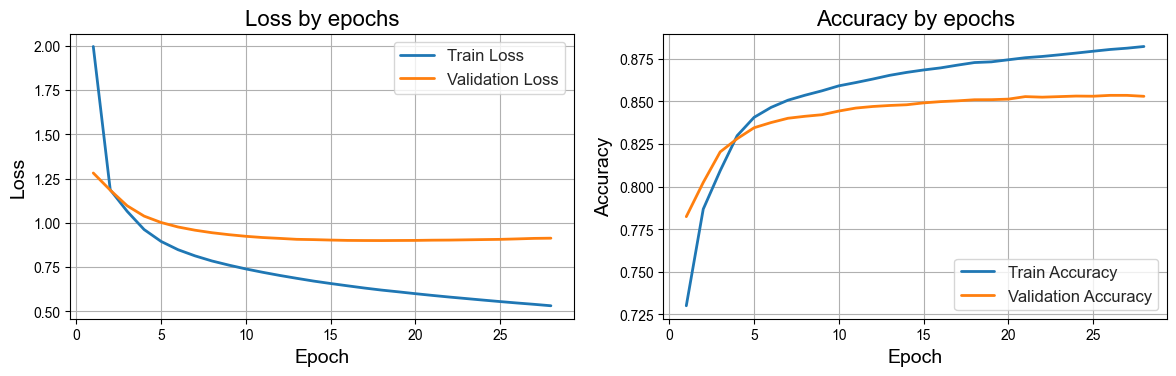

In [22]:
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

cfg.epochs = 50
cfg.lr = 1e-3

lr_schedule = CosineDecay(
        initial_learning_rate=cfg.lr,
        decay_steps=cfg.epochs,
        alpha=1e-4
    )

optimizer = Adam(learning_rate=lr_schedule)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1, 
                           restore_best_weights=True)


model.compile(loss='categorical_crossentropy', optimizer = "Adam", metrics=['accuracy'])

filename = 'QABot_model_v0.keras'
encoder_file = 'QABot_encoder_v0.keras'
decoder_file = 'QABot_decoder_v0.keras'

if os.path.exists(filename):
    # Load existing model
    model = load_model(filename)    
else:   
    # Train the model
    history = model.fit([encoder_input_sequences, decoder_input_sequences],
                        decoder_targets,
                        validation_split=0.20,
                        callbacks=[
                                early_stop,
                                ],
                        epochs = cfg.epochs, 
                        verbose=1,
                        )

    # save the model and enconder/decoder
    model.save(filename)
    encoder_model.save(encoder_file)
    decoder_model.save(decoder_file)
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.set(style="whitegrid", palette="muted", font_scale=1.2)


    epoch_count = range(1, len(history.history['accuracy']) + 1)

    # Primer gráfico: Loss
    sns.lineplot(
        x=epoch_count,
        y=history.history['loss'],
        label='Train Loss',
        linewidth=2,
        ax=axes[0]
    )
    sns.lineplot(
        x=epoch_count,
        y=history.history['val_loss'],
        label='Validation Loss',
        linewidth=2,
        ax=axes[0]
    )
    axes[0].set_title('Loss by epochs', fontsize=16)
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(loc='upper right', fontsize=12)
    axes[0].grid(True)

    # Segundo gráfico: Accuracy
    sns.lineplot(
        x=epoch_count,
        y=history.history['accuracy'],
        label='Train Accuracy',
        linewidth=2,
        ax=axes[1]
    )
    sns.lineplot(
        x=epoch_count,
        y=history.history['val_accuracy'],
        label='Validation Accuracy',
        linewidth=2,
        ax=axes[1]
    )
    axes[1].set_title('Accuracy by epochs', fontsize=16)
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(loc='lower right', fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [23]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [24]:
def answer_question(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [25]:
input_test = "Hi how are you?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Input: Hi how are you?
Representacion en vector de tokens de ids [11, 10, 7, 2]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0 11 10  7  2]]
Input: Hi how are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Response: i am fine


Gran respuesta!!

In [26]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Response: i love to read


Buena respuesta también!

In [27]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Response: i am a student


No responde adecuadamente :(

In [28]:
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_question(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0  0  0  0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Response: i am a student


Idem al caso anterior :(

**OBSERVACIONES**

- Se observa que en las primeras dos preguntas, las respuestas estuvieron acordes a lo esperado, mientras que para las últimas 2, la respuesta no tuvo coherencia con lo pedido.

### 6 - Conclusión

- El *accuracy* alcanzado aparenta ser muy bueno, no obstante, la respuestas obtenidas durante la prueba del modelo estuvieron acordes en algunos casos y fallaron en otros, aunque si es de resaltar que gramaticalmente estuvieron en todos los casos bien armadas las respuestas.